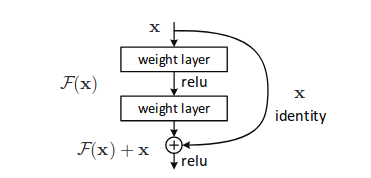

We will implement the following Resnets:
    
* Resnet 50
* Resnet 101
* Resnet 152

Most of the variants of resnets consist of

* A convolution block (Conv -> BN -> ReLU -> MaxPool)
* ResLayer blocks
* A classifier block with average Pooling and a Linear Layer


## Design:

* We have multiple resnet layers(given in list).Each layer contains multiple blocks.
* The 1st resnet layer is created with 3 residual blocks with 3X3 convolution and stride 1 (No downsampling is required.)
* From 2nd resnet layers, 
      1. Only the first convolution layer of the first block has stride 2, the rest of all the convolution layers are of stride 1. 
      2. Also for downsampling input, stride 2 convolution is applied.
      


In [1]:
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F

In [41]:
# resnet block
class block(nn.Module):
    def __init__(self,in_ch, intermediate_ch, stride=1, downsample=None):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=intermediate_ch,kernel_size=1)
        self.bn1 = nn.BatchNorm2d(num_features=intermediate_ch)
        self.conv2 = nn.Conv2d(in_channels=intermediate_ch,out_channels=intermediate_ch,kernel_size=3,padding=1,stride=stride)
        self.bn2 = nn.BatchNorm2d(num_features=intermediate_ch)
        self.conv3 = nn.Conv2d(in_channels=intermediate_ch,out_channels=intermediate_ch*self.expansion,kernel_size=1)
        self.bn3 = nn.BatchNorm2d(num_features=intermediate_ch*self.expansion)
        # sometimes we have to resize feature map before adding
        self.downsample = downsample
        
    def forward(self,x):
        identity = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        out = self.conv3(out)
        out = self.bn3(out)

        # if the skip conncetion has to be modified  (change channel_no or input_shape)
        if self.downsample is not None:
             identity = self.downsample(x)
    
        out += identity
        out = F.relu(out)
        return out
    
    
    

In [42]:
class ResNet(nn.Module):
    def __init__(self,block,layers, img_channels=3, num_classes=1000):
        super().__init__()
        # initial convolution block with maxpool
        self.image_channels = img_channels
        self.init_layer = nn.Sequential(
                      nn.Conv2d(self.image_channels, 64, kernel_size=7, stride=2, padding=3),
                      nn.BatchNorm2d(64),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                    )

        
        
        #ResNet blocks
        self.layer1 = self.make_layer(
            block, layers[0],  in_ch= 64 ,intermediate_ch=64, stride=1
        )
        self.layer2 = self.make_layer(
            block, layers[1], in_ch=64*4, intermediate_ch=128, stride=2
        )
        self.layer3 = self.make_layer(
            block, layers[2], in_ch=128*4, intermediate_ch=256, stride=2
        )
        self.layer4 = self.make_layer(
            block, layers[3],  in_ch=256*4, intermediate_ch=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.init_layer(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

        

    def make_layer(self, block, no_blocks, in_ch, intermediate_ch, stride):
        """
        for first layer we have all stride=1 for all blocks.
        From second layer, we have stride=2 for first block, rest of the blocks have stride=1.
        """
        downsample = None
        
        if stride != 1 or in_ch != intermediate_ch*4:
            downsample = nn.Sequential(
                nn.Conv2d(in_ch, intermediate_ch*4, kernel_size=1, stride=stride), 
                nn.BatchNorm2d(intermediate_ch*4,)                          
                                    )
        layers = []
        
        # first block of layer   #(64,64)64->64-64>256  #(256,128)256->128->128>512   
        layers.append(block(in_ch, intermediate_ch, stride, downsample))
        
        # we will multiply by 4 because flow is first block 64->64->128->64->64->128->64->64->128
        
        for _ in range(1, no_blocks):
            new_input_ch = intermediate_ch*4
            #(256,64)   #(512,128)
            layers.append(block(new_input_ch, intermediate_ch, stride=1))
        return nn.Sequential(*layers)
  



In [43]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)

In [44]:
res = ResNet50()
res

ResNet(
  (init_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [47]:
# testing
img = torch.randint(0,200,(3,224,224)).float()
img = img.view(-1,3,224,224)
print(img.shape)
out = res(img)
print(out.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
